## Demo notebook of Dirichlet $\beta$-VAE

This notebook reproduces the experiment of on the effect of the regularization factor $\beta$ on the synthetic dataset. 

In [1]:
import os
from scipy.io import loadmat

import torch
import torch.nn as nn
from   torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from utils.data.synth_data import get_synth_dataset 
from utils.data.hsi_dataset_class import HSIDataset
from utils.data.real_data         import get_dataset

from model.dir_vae import DirVAE

from utils.optimization.constraint  import NonNegConstraint
from utils.optimization.optim_utils import get_optimizer

from utils.loss.losses_utils import (
    get_reconstruction_loss_fn,
    get_regularization_loss_fn
)

from trainer import UnsupervisedTrainer
from utils.metrics import get_average_accuracy_on_M, get_accuracy_on_M

from utils.logs_fn import create_log_folder, log_metrics, log_figure


### Data

In [2]:
path_to_data = f"./Datasets/Synth_alpha_4.0_snr_40_n_ems_3/synth_alpha_4.0_snr_40_n_ems_3.mat"
#path_to_data = f"./Datasets/Synth_alpha_4.0_snr_30_n_ems_3/synth_alpha_4.0_snr_40_n_ems_3.mat"
#path_to_data = f"./Datasets/Synth_alpha_4.0_snr_20_n_ems_3/synth_alpha_4.0_snr_40_n_ems_3.mat"

n_bands, n_materials, wavelenghts, n_ems, \
             n_samples, n_outliers, SNR, sigma, \
                M, A, eps, Y, max_value, \
                 n_rows, n_cols = get_synth_dataset(path_to_data)

n_ems     = A.shape[0]
n_bands   = Y.shape[1]
n_samples = Y.shape[0]

dataset = HSIDataset(0,
                     Y / Y.max(), M, A, 
                     n_ems, n_bands, n_samples, 
                     None, None, 
                     "Synth_alpha_4.0_snr_40_n_ems_3",
                     data_type="float32",
                     random_seed=1234)

dataloader = DataLoader(dataset, 
                        batch_size=200, 
                        shuffle=True)  

/home/ddoutsas/cleanprojects/dirichlet-beta-vae-for-bhu/utils/data/hsi_dataset_class.py:80: UserWarning: Cannot verify shapes for the provided dataset.                                   Please make sure of the sanity check by yourself.
  warnings.warn("Cannot verify shapes for the provided dataset. \


### Model

In [3]:
hidden_dims = [3 * n_ems, 
               2 * n_ems, 
               1 * n_ems, 
               1]

model = DirVAE(n_bands                = n_bands,
                n_ems                 = n_ems,
                beta                  = 1.,
                hidden_dims           = hidden_dims,
                encoder_activation_fn = nn.LeakyReLU(),
                encoder_batch_norm    = True
)
constraint = NonNegConstraint([model.decoder[0]])
model.init_decoder("he")
constraint.apply()

init_M = model.get_endmembers().cpu()

### Training

In [4]:
# parameters of targeted Dirichlet distribution
concentration_sets = 4.0 * np.array([1.0 for i in range(n_ems)]).reshape(1,-1)

rec_loss_fn = get_reconstruction_loss_fn("mse").to("cuda")
reg_loss_fn = get_regularization_loss_fn(concentration_sets, "gamma_div" ).to("cuda")

In [5]:
optimizer_fn = get_optimizer("tf_rms")
optimizer    = optimizer_fn(model.parameters(), 
                            1e-3,
                            0.99)

In [6]:
n_epochs = 400
reg_factor = 1e-1

trainer = UnsupervisedTrainer()
trained_model, results = trainer.train(n_epochs,
                                       model,
                                       dataloader,
                                       optimizer,
                                       rec_loss_fn,
                                       reg_loss_fn,
                                       reg_factor,
                                       constraint,
                                       True,
                                       False
                                       )

The model will be running on cuda:0 device.



100%|██████████| 400/400 [00:46<00:00,  8.70it/s]


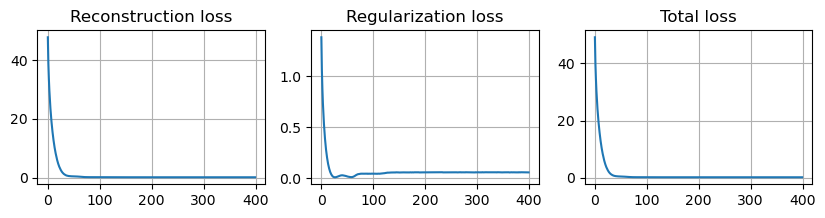

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(10,2))

axs[0].plot(results["reconstruction_loss"])
axs[0].set_title("Reconstruction loss")
axs[0].grid()

axs[1].plot(results["regularization_loss"])
axs[1].set_title("Regularization loss")
axs[1].grid()

axs[2].plot(results["total_loss"])
axs[2].set_title("Total loss")
axs[2].grid()

plt.show()

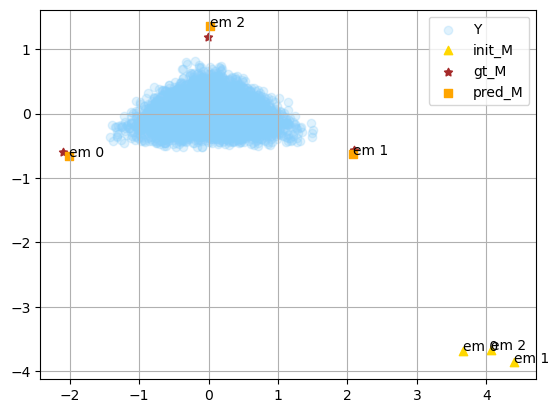

In [8]:
# compute results
pred_M = trained_model.get_endmembers().cpu()

#sad metric
avg_sad = get_average_accuracy_on_M(pred_M, 
                                    torch.from_numpy(dataset.M), 
                                    criterion=get_reconstruction_loss_fn("sad"))
sad_by_ems = get_accuracy_on_M(pred_M, 
                                torch.from_numpy(dataset.M),
                                criterion=get_reconstruction_loss_fn("sad"))
#mse metric
avg_mse = get_average_accuracy_on_M(pred_M, 
                                    torch.from_numpy(dataset.M), 
                                    criterion=get_reconstruction_loss_fn("mse"))
mse_by_ems = get_accuracy_on_M(pred_M, 
                                torch.from_numpy(dataset.M),
                                criterion=get_reconstruction_loss_fn("mse"))

# create log folder to store results
path_to_log_dir = create_log_folder("./logs")

log_metrics(avg_sad, sad_by_ems, avg_mse, mse_by_ems, path_to_log_dir)
log_figure(Y,
           pred_M,
           dataset.M,
           init_M,
           path_to_log_dir,
           debug=True,
           show=True,
           verbose=False,
           save=True,
           )